# Differences between dynamics simulation and OpenRocket

I'm seeing some weird discrepancies between my simulator and OpenRocket. Here I discuss them and figure out where they might come from.

## Setup

In [34]:
# importing OpenRocket data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.interpolate as interp
%matplotlib inline

sim = pd.read_csv("subarktos/subarktos_sim_heavy_no_main.csv", comment='#')
read_t = np.array(sim['Time (s)'])
read_alt = np.array(sim['Altitude (ft)'])
read_vel = np.array(sim['Vertical velocity (ft/s)'])
read_acc = np.array(sim['Vertical acceleration (ft/s^2)'])
t_apogee = 16.208 # I read this off the csv, ideally I'd parse the comments
read_drag = np.array(sim['Drag force (N)'])
read_thrust = np.array(sim['Thrust (N)'])
read_mass = np.array(sim['Mass (oz)']) * 0.0283495 
read_gravity = np.array(sim['Gravitational acceleration (ft/s^2)'])
read_grav_force = read_gravity * read_mass / 3.28

def force(t):
    n = np.where(read_t == t)[0][0]
    if t < t_apogee:
        return read_thrust[n] - read_drag[n] - read_gravity[n]
    else:
        return read_drag[n] - read_gravity[n]
    
read_force = (np.vectorize(force))(read_t)

Text(0,0.5,'Drag (N)')

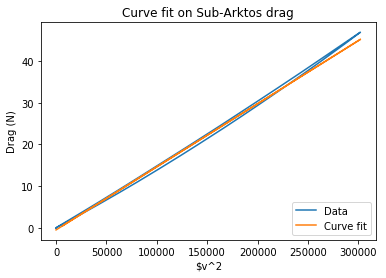

In [35]:
# to get the drag coefficient for subarktos, we curve-fit drag to velocity squared over the ascent.
n_ascent = np.where(np.isclose(read_t, t_apogee, atol=1e-2))[0][0]
v2 = read_vel**2
plt.plot(v2[np.arange(0,n_ascent,1)], read_drag[np.arange(0,n_ascent,1)], label="Data")
slope, intercept, _, _, _ = stats.linregress(v2[np.arange(0,n_ascent,1)],read_drag[np.arange(0,n_ascent,1)])
plt.plot(read_vel**2, slope*(read_vel**2) + intercept, label="Curve fit")
plt.legend(loc='lower right')
plt.title("Curve fit on Sub-Arktos drag")
plt.xlabel(r"$v^2")
plt.ylabel("Drag (N)")

In [36]:
# running a dynamic sim

from rocket import *

mass = read_mass[-1] #kg (ideally I'd read this off the openrocket or even better weigh the rocket, 
# but real life is sad)
motor = Motor(1.223 - 0.713, 0, "subarktos/J450.txt") # motor starts with a mass 1.223 kg and ends with 0.713 kg.
# These are standard numbers you can look up for any COTS motor. Slightly jank with final mass = 0 though.
drogue = Parachute(0.3, 1.8, "Drogue")
#main = Parachute(0.9, 2.2, "Main", alt=800)
altimeter = Sensor(0, 5.54, None) # sensor is reading state variable 0 (altitude)
accelerometer = Sensor(2, 62.9, None) # reading state variable 2
drag = slope # determined via curve fitting to drag = -bv*2
subarktos = Rocket(mass, [drogue], [motor], [altimeter, accelerometer], drag)

times, states, inputs = subarktos.simulate(dt=0.001, timeout=120)

Hit apogee at altitude 5503.64 ft
Deploying Drogue at t = 20.34 s
Simulation ended at t = 89.023 s due to end condition.


## Basic Analysis

The Sub-Arktos apogee is supposed to be about 1000 ft lower than that. This difference is very weird given that

- both simulations are using the same thrust curve
- both simulations have basically the same drag because I did a curve-fit to their drag data

Plotting the state-variable curves, you'll see some pretty big differences between the two sims.

Text(0.5,1,'Altitude over time from both sims')

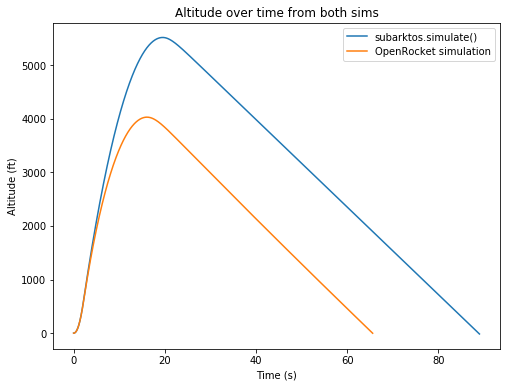

In [37]:
plt.figure(figsize=(8,6))
plt.plot(times, 3.28*states[0], label='subarktos.simulate()')
plt.plot(read_t, read_alt, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Altitude (ft)")
plt.title("Altitude over time from both sims")

Text(0.5,1,'Velocity over time from both sims')

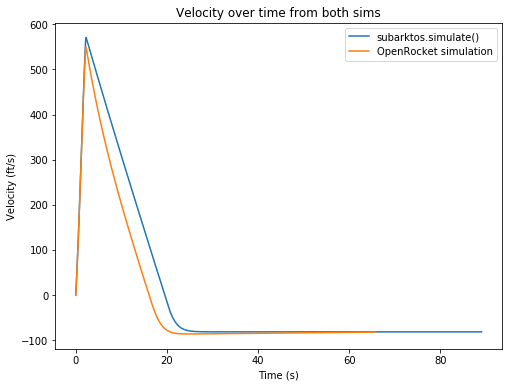

In [38]:
plt.figure(figsize=(8,6))
plt.plot(times, 3.28*states[1], label='subarktos.simulate()')
plt.plot(read_t, read_vel, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (ft/s)")
plt.title("Velocity over time from both sims")

Text(0.5,1,'Acceleration over time from both sims')

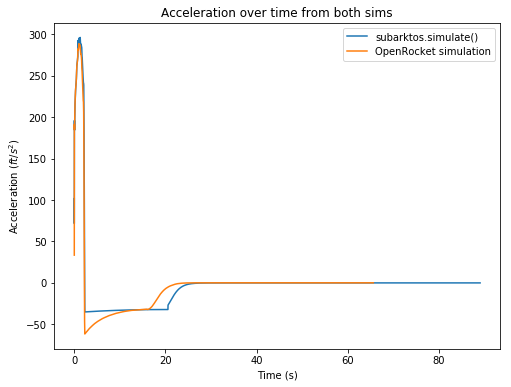

In [39]:
plt.figure(figsize=(8,6))
plt.plot(times, 3.28*states[2], label='subarktos.simulate()')
plt.plot(read_t, read_acc, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel(r"Acceleration ($ft/s^2$)")
plt.title("Acceleration over time from both sims")

I can show that these differences trace back to the differences in the acceleration, rather than numerical integration issues or anything else. Let's try using the OpenRocket acceleration * mass as the subarktos.simulate force input, and see what happens.

In [40]:
def test_acc_differences(subarktos, read_t, read_acc):
    def new_ext_input(t):
        if t < np.min(read_t) or t > np.max(read_t):
            return (0, "OpenRocket sim data")
        return (interp.interp1d(read_t, read_acc)(t)/3.28 * interp.interp1d(read_t, read_mass)(t), 
                "OpenRocket sim data")

    subarktos.ext_input = new_ext_input
    return subarktos

subarktos = test_acc_differences(subarktos, read_t, read_acc)
times_diff, states_diff, _ = subarktos.simulate(dt=0.001, timeout=120)

Hit apogee at altitude 3922.71 ft
Deploying Drogue at t = 16.69 s
Simulation ended at t = 59.569 s due to end condition.


Text(0.5,1,'Altitude over time from both sims (input force from OpenRocket)')

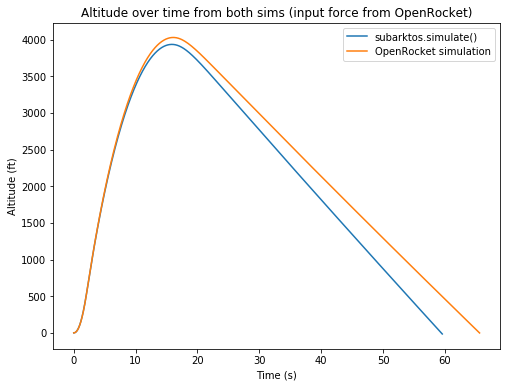

In [41]:
plt.figure(figsize=(8,6))
plt.plot(times_diff, 3.28*states_diff[0], label='subarktos.simulate()')
plt.plot(read_t, read_alt, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Altitude (ft)")
plt.title("Altitude over time from both sims (input force from OpenRocket)")

Text(0.5,1,'Velocity over time from both sims (input force from OpenRocket)')

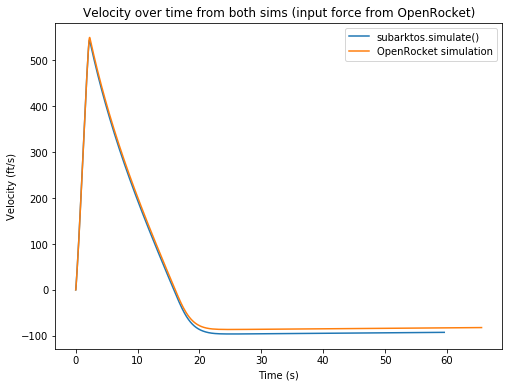

In [42]:
plt.figure(figsize=(8,6))
plt.plot(times_diff, 3.28*states_diff[1], label='subarktos.simulate()')
plt.plot(read_t, read_vel, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (ft/s)")
plt.title("Velocity over time from both sims (input force from OpenRocket)")

Text(0.5,1,'Acceleration over time from both sims (input force from OpenRocket)')

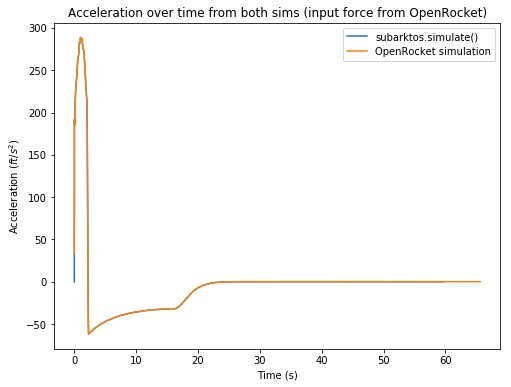

In [43]:
plt.figure(figsize=(8,6))
plt.plot(times_diff, 3.28*states_diff[2], label='subarktos.simulate()')
plt.plot(read_t, read_acc, label='OpenRocket simulation')
plt.legend(loc='upper right')
plt.xlabel("Time (s)")
plt.ylabel(r"Acceleration ($ft/s^2$)")
plt.title("Acceleration over time from both sims (input force from OpenRocket)")

## Acceleration Error

Barring some very slight differences that you can still attribute to zero error (because I start my sim at zero position, velocity, acceleration but OpenRocket starts with nonzero acceleration), these two are basically the same now. So we're left with the conclusion that the big discrepancy in apogee, the relative time delay, etc. are caused by the differences in the two acceleration curves. The two major points of interest there are the slight ramp-up that my sim seems to have that OpenRocket doesn't, and the dip after motor burnout and before apogee that OpenRocket has and my sim doesn't. Let's look at those.

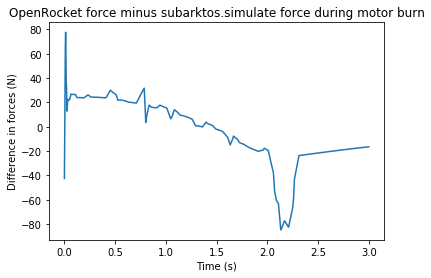

In [44]:
# overall differences

test_time = np.linspace(0, 3, 1000)
simforce = np.vectorize(interp.interp1d(times, inputs[0]))(test_time)
orforce = np.vectorize(interp.interp1d(read_t, read_force))(test_time)
plt.xlabel("Time (s)")
plt.ylabel("Difference in forces (N)")
plt.title("OpenRocket force minus subarktos.simulate force during motor burn")
plt.plot(test_time, orforce - simforce)

This confirms my suspicions: there's a huge spike right at the start, and a decently big dip around burnout. Let's look at the first of those.

## Thrust curve interpolation analysis

(123.17299165300001, '[178.449, -55.276008347, -0.0, 0]\n')


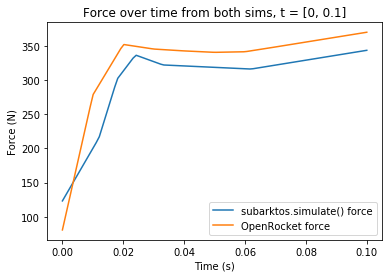

In [45]:
# force curve right at the start

subarktos = Rocket(mass, [drogue], [motor], [altimeter, accelerometer], drag)
print(subarktos.ext_input(0))
def view_force(min_t, max_t, location='lower right'):
    test_time = np.linspace(min_t,max_t,100)
    simforce = np.vectorize(lambda x: subarktos.ext_input(x)[0])(test_time)
    orforce = np.vectorize(interp.interp1d(read_t, read_force))(test_time)
    plt.plot(test_time, simforce, label='subarktos.simulate() force')
    plt.plot(test_time, orforce, label='OpenRocket force')
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.legend(loc=location)
    plt.title("Force over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")
    
view_force(0,0.1)

It's pretty clear from the slopes that OpenRocket is linearly interpolating thrust curve data in the same way that subarktos.simulate does. The difference is in a constant offset, likely caused by the different start points. In particular, subarktos.simulate starts out dipping below zero before it picks back up. This is because the thrust is being interpolated between (t = 0s, f = 0N) and (t = 0.012s, f = 270.708N), the first point on the thrust curve, so for a few milliseconds, the thrust is lower than the weight (about 50N) and so the net force is directed down. OpenRocket seems to just start its thrust off at zero time and thrust > weight to avoid this. We can actually look at what its thrust is between t = 0 and t = 0.012 against that of subarktos.simulate:

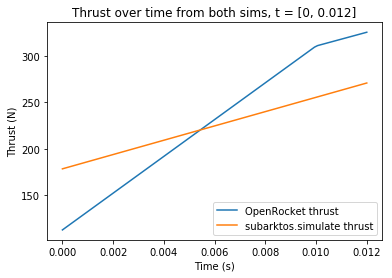

In [46]:
def view_thrust(min_t, max_t, location='lower right'):
    test_time = np.linspace(min_t, max_t, 100)
    orthrust = (np.vectorize(interp.interp1d(read_t, read_thrust))(test_time))
    simthrust = (np.vectorize(lambda x: float(subarktos.ext_input(x)[1].split()[0][1:-1])))(test_time) #jank indexing yay
    plt.xlabel("Time (s)")
    plt.ylabel("Thrust (N)")
    plt.plot(test_time, orthrust, label="OpenRocket thrust")
    plt.plot(test_time, simthrust, label="subarktos.simulate thrust")
    plt.legend(loc=location)
    plt.title("Thrust over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")
    
view_thrust(0,0.012)

And let's look at it up to the fourth data point of the interpolation:

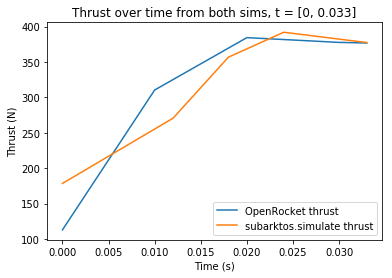

In [47]:
view_thrust(0,0.033)

Barring some slight extra optimization OpenRocket seems to be doing where it starts changing its slope just before an interpolation point, these two would be basically the same if not for subarktos.simulate starting its thrust at 0. Let's see if OpenRocket starts its thrust anywhere specific, say, some nice fraction of the interpolation point.

In [48]:
read_thrust[0]/270.708

0.41668513675251556

That looks sort of familiar; let's multiply by the time of the interpolation point.

In [49]:
read_thrust[0]/270.708 * 0.012

0.005000221641030187

So OpenRocket's start point formula seems to be initial thrust = (0.005/initial time) * first thrust reading. This is basically like arbitrarily picking a slope of 0.005 for the first bit of your interpolation, and extrapolating back from that to get an initial point.

How about at burnout?

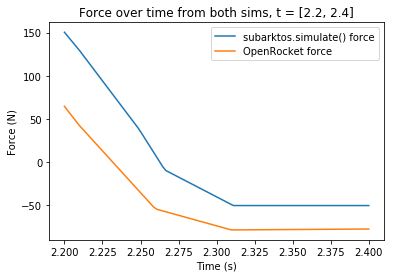

In [50]:
view_force(2.2, 2.4, location='upper right')

Going in that looks a little weird, because again they're supposedly interpolating from the same thrust curve, and yet they start off (in the middle of the interpolation range) with a discrepancy of around 100 N.

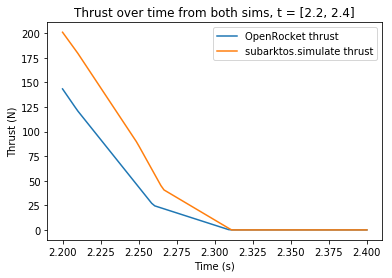

In [51]:
view_thrust(2.2, 2.4, location='upper right')

The discrepancy in thrust seems to come from the same 'pre-optimization' OpenRocket does where it changes its slope just before an interpolation point rather than at the point. I'm just going to neglect that. 

## Other force effects

However, after burnout just after 2.3s, there's a discrepancy in the two overall forces. This could either come from gravity or drag. OpenRocket does consider different values of g over time:

0.04046440688514651

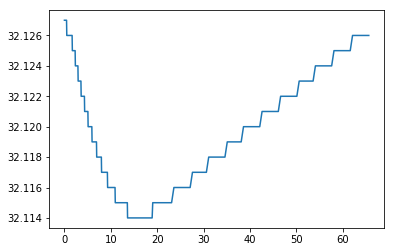

In [52]:
plt.plot(read_t, read_gravity)
(max(read_gravity) - min(read_gravity))/max(read_gravity) * 100

But that seems pretty negligible. Since I calculated drag from OpenRocket data in the first place, we've already seen the graph of the discrepancy between those, and that's pretty negligible too. The last thing that might cause a difference is mass.

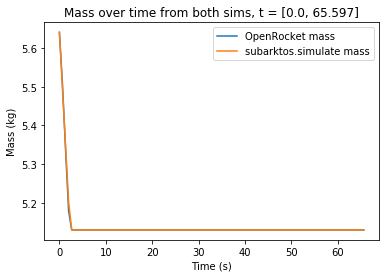

In [53]:
def view_mass(min_t, max_t, location='lower right'):
    # yeah I know I've basically written the same function three times and just switched out one variable
    # I could try and be fancy and have a function edit variable names inside itself
    # but no ctrlC/V is just easier
    test_time = np.linspace(min_t, max_t, 100)
    ormass = (np.vectorize(interp.interp1d(read_t, read_mass))(test_time))
    simmass = (np.vectorize(subarktos.get_mass)(test_time))
    plt.xlabel("Time (s)")
    plt.ylabel("Mass (kg)")
    plt.plot(test_time, ormass, label="OpenRocket mass")
    plt.plot(test_time, simmass, label="subarktos.simulate mass")
    plt.legend(loc=location)
    plt.title("Mass over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")
    
view_mass(min(read_t), max(read_t), location='upper right')

Those seem to agree pretty well, but let's look a little closer around when the motor is burning.

5.4998029999531184e-05


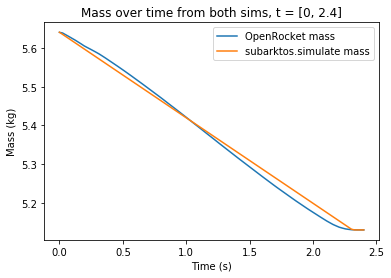

In [54]:
view_mass(0, 2.4, location='upper right')
print(interp.interp1d(read_t, read_mass)(2.35) - subarktos.get_mass(2.35))

Again, negligible. This definitely wouldn't cause the ~50N difference just after burnout. So what would? Let's look at the breakdown of the input forces to subarktos. It's actually a bit difficult to do this based on how I've set up the simulate function, so I'm just going to rerun that 0.1s of simulation.

In [55]:
subarktos.reset()
t = 2.3
dt = 0.01
subarktos.state = states.T[2300]
for _ in range(10):
    _, u_status, subarktos.state, _ = subarktos.predict(t, dt)
    print(u_status)  # string with [thrust, gravity, rocket drag, chute drag]
    t += dt
subarktos.reset()

[10.089200000000126, -50.301798048427955, -4.562735961890704, 0]

[0.9172000000003067, -50.28017104712981, -4.558204490686202, 0]

[0, -50.278008347000004, -4.553160042261773, 0]

[0, -50.278008347000004, -4.547603663286623, 0]

[0, -50.278008347000004, -4.542004390259401, 0]

[0, -50.278008347000004, -4.536409135531953, 0]

[0, -50.278008347000004, -4.53081790003371, 0]

[0, -50.278008347000004, -4.525230682299006, 0]

[0, -50.278008347000004, -4.519647480863325, 0]

[0, -50.278008347000004, -4.514068294263412, 0]



That drag force should be about 10x higher.

## Curve fitting is a lie

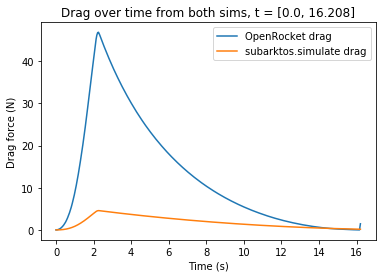

In [56]:
def view_drag_ascent(min_t, max_t, location='lower right',magic=0):
    test_time = np.linspace(min_t, max_t, int(1000*(max_t - min_t)))
    ordrag = (np.vectorize(interp.interp1d(read_t, read_drag))(test_time))
    simdrag = subarktos.b_drag * states[1][int(min_t*1000):int(max_t*1000)+magic]**2
    plt.xlabel("Time (s)")
    plt.ylabel("Drag force (N)")
    plt.plot(test_time, ordrag, label="OpenRocket drag")
    plt.plot(test_time, simdrag, label="subarktos.simulate drag")
    plt.legend(loc=location)
    plt.title("Drag over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")
    
view_drag_ascent(min(read_t), t_apogee, location='upper right')

That's deeply weird considering that that's not what the fit looked like at all. This does pretty much explain the discrepancy just after burnout though:

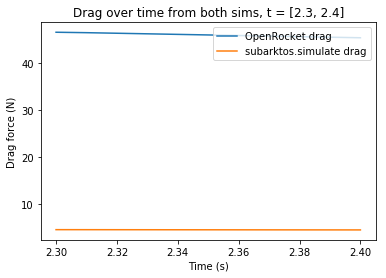

In [57]:
view_drag_ascent(2.3, 2.4, location='upper right')

CURVE FITTING IS A LIE

## Parachute drag

I only plotted up to apogee on the last plot because after that OpenRocket starts including parachute drag. We can look at that separately:

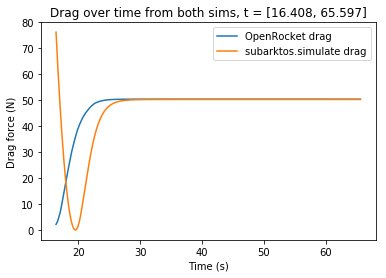

In [25]:
def view_drag_descent(min_t, max_t, location='lower right', magic=-1):
    test_time = np.linspace(min_t, max_t, int(1000*(max_t - min_t)))
    ordrag = (np.vectorize(interp.interp1d(read_t, read_drag))(test_time))
    simdrag = (subarktos.b_drag + subarktos.parachutes[0].b_drag) * states[1][int(min_t*1000):int(max_t*1000)+magic]**2
    plt.xlabel("Time (s)")
    plt.ylabel("Drag force (N)")
    plt.plot(test_time, ordrag, label="OpenRocket drag")
    plt.plot(test_time, simdrag, label="subarktos.simulate drag")
    plt.legend(loc=location)
    plt.title("Drag over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")
    
view_drag_descent(np.round(t_apogee + 0.2, 3), max(read_t), location='upper right')
# don't know why there's an off-by-one error in the indexing and I don't really care enough to fix it in general.

This is interesting - let's look between apogee and 30s a little more closely.

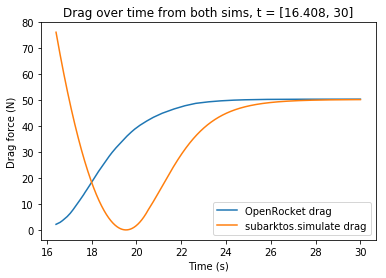

In [26]:
view_drag_descent(16.408, 30)

The dynamic simulation has the same sort of massive spike from a new force that you get from main deployment, and I'm unsure why you physically wouldn't expect that as it seems you don't get it in OpenRocket. It's likely that OpenRocket just ramps up its input force over some time rather than delivering all of it as a sort of Dirac delta. Although I'm also not totally sure why the subarktos.simulate plot _isn't_ just a Dirac delta, i.e. why, over a few seconds, it dips down to 0 and then settles back up to the steady value.

In [27]:
# Let's try giving the Sub-Arktos drogue a gradual ramp up, over say two seconds.
# This'll be very specific numbers rather than a general implementation, just to see what happens.

def b_drag(t):
    if t - 16.208 < 0.2:
        return 0
    elif t - 16.408 < 2:
        c = (t - 16.408)/2
    else:
        c = 1
    return c * subarktos.parachutes[0].b_drag + subarktos.b_drag

def view_drag_descent_edited(min_t, max_t, location='lower right', magic=-1):
    test_time = np.linspace(min_t, max_t, int(1000*(max_t - min_t)))
    ordrag = (np.vectorize(interp.interp1d(read_t, read_drag))(test_time))
    simdrag = np.vectorize(b_drag)(test_time) * states[1][int(min_t*1000):int(max_t*1000)+magic]**2
    plt.xlabel("Time (s)")
    plt.ylabel("Drag force (N)")
    plt.plot(test_time, ordrag, label="OpenRocket drag")
    plt.plot(test_time, simdrag, label="subarktos.simulate drag")
    plt.legend(loc=location)
    plt.title("Drag over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")

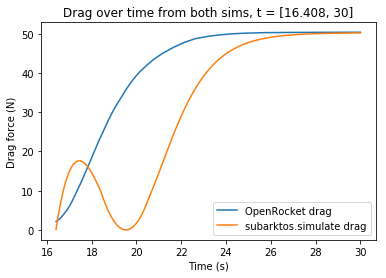

In [28]:
view_drag_descent_edited(16.408, 30)

That seems better, but there's still a time offset and I'm not sure why there's the initial jump only to settle back down and then eventually go back up again. Maybe it's because velocity isn't evolving based on this new drag. Let's incorporate this into the Sub-Arktos drogue parachute and rerun the simulation.

In [29]:
def change_chute_drag(parachute, open_time):
    def drag(velocity, t):
        if not parachute.deployed:
            return 0
        delay = parachute.t_deployed + parachute.CHUTE_OPEN_DELAY
        if t < delay:
            return 0
        elif open_time == 0 or t - delay >= open_time:
            c = 1
        else:
            c = (t - delay)/open_time
        return c * parachute.b_drag * velocity**2

    parachute.drag = drag
    return parachute


subarktos.parachutes[0] = Parachute(0.3, 1.8, "Drogue")
subarktos.parachutes[0] = change_chute_drag(subarktos.parachutes[0], 2)
times, states, inputs = subarktos.simulate(dt=0.001, timeout=120)

Hit apogee at altitude 5502.72 ft
Deploying Drogue at t = 20.338 s
Simulation ended at t = 88.763 s due to end condition.


Not much seemed to change; ground hit was about 0.1s later. Let's check out drag:

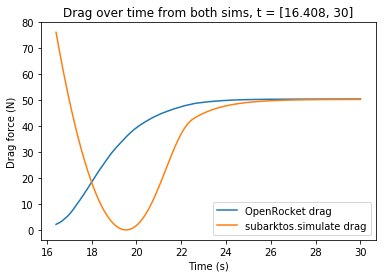

In [30]:
view_drag_descent(16.408, 30)

Weirdly, even with the ramp-up in the force, the drag is still coming down from a peak. If you're at apogee, the drag is supposed to be 0 because there's no velocity, so the OpenRocket version makes sense and I have no idea what my simulation is doing. I've had problems with apogee detection before; maybe I'd better try and refine that.

Hit apogee at altitude 5502.72 ft
Deploying Drogue at t = 20.338 s
Simulation ended at t = 87.943 s due to end condition.


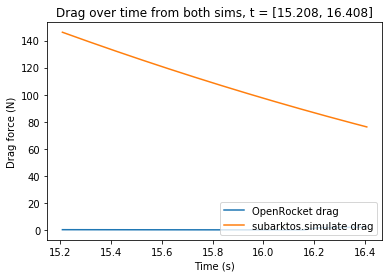

In [31]:
subarktos.parachutes[0] = change_chute_drag(subarktos.parachutes[0], 5)
times, states, inputs = subarktos.simulate(dt=0.001, timeout=120)
view_drag_descent(15.208,16.408,magic=0)

These are clearly being caused by differences in the velocity, because that's the only time-varying input to drag pre-deployment. But when we plotted velocity way back when we'd just run the first simulation, the difference wasn't that drastic. Let's look at the velocity differences over this time period.

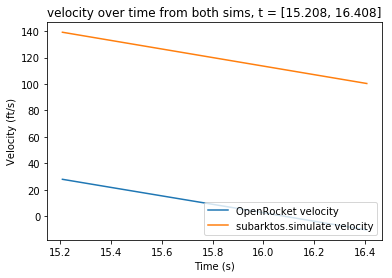

In [32]:
def view_velocity(min_t, max_t, location='lower right'):
    test_time = np.linspace(min_t, max_t, 100)
    orthrust = (np.vectorize(interp.interp1d(read_t, read_vel))(test_time))
    simthrust = (np.vectorize(interp.interp1d(times, states[1])))(test_time) * 3.28
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (ft/s)")
    plt.plot(test_time, orthrust, label="OpenRocket velocity")
    plt.plot(test_time, simthrust, label="subarktos.simulate velocity")
    plt.legend(loc=location)
    plt.title("velocity over time from both sims, t = [" + str(min_t) + ", " + str(max_t) + "]")
    
view_velocity(15.208, 16.408)

yeah uh that's pretty bad. How bad is it over all time?

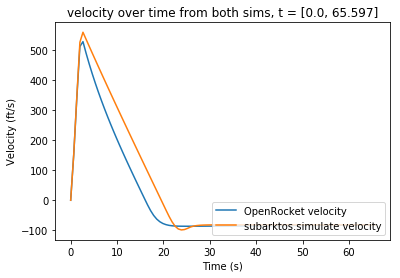

In [33]:
view_velocity(min(read_t), max(read_t))

Seems like it's fine up till burnout, and their slopes are similar after burnout (the dip at apogee is probably caused by the little chute opening experiment) but with a constant offset. This pretty much has to be caused by the differences in acceleration. It's all a vicious cycle.

## Conclusion

Tracking errors in simulation is sort of circular. It seems like what happened is:

    - slight differences in thrust curve interpolation caused
    - an underestimate in position and velocity, which caused
    - a underestimated drag force after burnout, which caused
    - overestimates of position/velocity/accel., which caused
    - a higher/delayed apogee than OpenRocket's, which caused
    - a longer and more gradual descent with the drogue chute
    
(I spent so long rewriting this to make every point the same width)

Also, something in this sequence probably caused the rocket state at apogee to be different than you'd expect, i.e. the rocket doesn't hang in the air with zero velocity and zero drag at apogee. As far as I can tell, this wouldn't propagate to any other simulation errors, but is a big error in and of itself.

An easy next step if we're looking to match OpenRocket is to implement their method of thrust curve interpolation - or better yet